In [1]:
#!pip install --upgrade ucimlrepo   
from ucimlrepo import fetch_ucirepo
import pandas as pd

import utils
import models
import hyperparameter_tuning
import evaluation

import importlib
importlib.reload(utils)
importlib.reload(models)
importlib.reload(hyperparameter_tuning)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\vale3\\OneDrive\\Desktop\\Statistical methods for machine learning\\Project_Stighezza\\evaluation.py'>

# Download the Mushroom dataset

This cell loads the Secondary Mushroom dataset either from the UCI repository (server mode) or a local CSV file (local mode). It extracts features (X), target labels (y), and metadata, and it checks the class distribution to assess dataset balance. The local mode serves as a fallback in case of connection issues with the server, as the UCI page (https://archive.ics.uci.edu/dataset/848/secondary+mushroom+dataset) sometimes experiences bad gateway errors or other connectivity problems. In such cases, the dataset is accessed locally.

In [2]:
# SERVER MODE
try:
    # Attempt to fetch the Secondary Mushroom dataset from UCI repository
    secondary_mushroom = fetch_ucirepo(id=848)

    # Extract features and target as pandas DataFrames
    X = secondary_mushroom.data.features  # Feature data
    y = secondary_mushroom.data.targets   # Target data (class labels)

    print("Dataset successfully loaded from UCI server.")

    display(secondary_mushroom.variables)


# LOCAL MODE
except Exception as e:

    print(f"Failed to load dataset from UCI server: {e}\nSwitching to local mode...")
    

    data = pd.read_csv("secondary_data.csv", sep=';')   # Load dataset from local CSV file
    y = data.iloc[:, 0]     # Target column (class labels)
    X = data.iloc[:, 1:]    # Feature columns
    
    print("Dataset successfully loaded from local file.", end="\n"*2)

# Analyze class distribution to check if the dataset is balanced
print("Class distribution (absolute counts):", y.value_counts() if isinstance(y, pd.Series) else y["class"].value_counts(), sep="\n", end="\n"*2)
print("Class distribution (normalized proportions):", y.value_counts(normalize=True) if isinstance(y, pd.Series) else y["class"].value_counts(normalize=True), sep="\n",  end="\n"*2)

print(f"{'Dimensions of features': <25}: {X.shape} \n{'Dimensions of labels':<25}: {y.shape}")

Dataset successfully loaded from UCI server.


,name,role,type,demographic,description,units,missing_values
0,class,Target,Categorical,None,None,None,no
1,cap-diameter,Feature,Continuous,None,None,None,no
2,cap-shape,Feature,Categorical,None,None,None,no
3,cap-surface,Feature,Categorical,None,None,None,yes
4,cap-color,Feature,Categorical,None,None,None,no
5,does-bruise-or-bleed,Feature,Categorical,None,None,None,no
6,gill-attachment,Feature,Categorical,None,None,None,yes
7,gill-spacing,Feature,Categorical,None,None,None,yes
8,gill-color,Feature,Categorical,None,None,None,no
9,stem-height,Feature,Continuous,None,None,None,no


Class distribution (absolute counts):
class
p    33888
e    27181
Name: count, dtype: int64

Class distribution (normalized proportions):
class
p    0.554913
e    0.445087
Name: proportion, dtype: float64

Dimensions of features   : (61069, 20) 
Dimensions of labels     : (61069, 1)


# Split dataset into training and test sets

This cell splits the Secondary Mushroom dataset into training and test sets using the `split_train_test` function from the `utils` module.

In [3]:
X_train, X_test, y_train, y_test = utils.split_train_test(X, y, test_size=0.2)
X_train, X_test, y_train, y_test = utils.reset_indices([X_train, X_test, y_train, y_test])

print(f"{'Training features shape':<25}: {X_train.shape}")
print(f"{'Training labels shape':<25}: {y_train.shape}")
print(f"{'Test features shape':<25}: {X_test.shape}")
print(f"{'Test labels shape':<25}: {y_test.shape}")

Training features shape  : (48856, 20)
Training labels shape    : (48856, 1)
Test features shape      : (12213, 20)
Test labels shape        : (12213, 1)


## Data preprocessing
This cell identifies columns in the training set with more than 75% missing values, then it removes them from both the training and test sets to improve data quality.

In [4]:
missing_values = X_train.isnull().mean()                        # Calculate the proportion of missing values in each column of the training set
missing_values = missing_values[missing_values > 0.75] * 100    # Filter columns with more than 75% missing values and convert to percentage

# Display columns to be dropped (due to high missing values)
if not missing_values.empty:
    print("Columns to be dropped (missing values > 75%):")
    for col, percentage in missing_values.items():
        print(f"{'  ' + col:<25}: {percentage:.2f}% missing values")
else:
    print("No columns have more than 75% missing values.")

# Display dimensions of training and test sets (before dropping columns)
print("\nDataset shapes (BEFORE dropping columns):")
print(f"{'  Training set shape':<25}: {X_train.shape}")
print(f"{'  Test set shape':<25}: {X_test.shape}\n")

# Drop columns with high missing values from training and test sets
X_train = X_train.drop(columns=missing_values.index)
X_test = X_test.drop(columns=missing_values.index)

# Display dimensions of training and test sets (after dropping columns)
print("Dataset shapes (AFTER dropping columns):")
print(f"{'  Training set shape':<25}: {X_train.shape}")
print(f"{'  Test set shape':<25}: {X_test.shape}")

Columns to be dropped (missing values > 75%):
  stem-root              : 84.41% missing values
  veil-type              : 94.68% missing values
  veil-color             : 87.85% missing values
  spore-print-color      : 89.75% missing values

Dataset shapes (BEFORE dropping columns):
  Training set shape     : (48856, 20)
  Test set shape         : (12213, 20)

Dataset shapes (AFTER dropping columns):
  Training set shape     : (48856, 16)
  Test set shape         : (12213, 16)


This cell imputes missing values in the Secondary Mushroom dataset:
- Using `utils.calculate_class_statistics`, it calculates medians for continuous features and modes for categorical features, using the training set.
- Using `utils.fill_missing_values`, it fills missing values in both training and test sets using these statistics to ensure consistency.

In [5]:
print(utils.NaN_summary(X_train, X_test, "BEFORE"), end="\n"*2)

medians, modes = utils.calculate_class_statistics(X_train)
X_train = utils.fill_missing_values(X_train, medians, modes)
X_test = utils.fill_missing_values(X_test, medians, modes)

print(utils.NaN_summary(X_train, X_test, "AFTER"))

   Dataset  Number of NaN (BEFORE)
0  X_train                   71646
1   X_test                   18016

   Dataset  Number of NaN (AFTER)
0  X_train                      0
1   X_test                      0


This cell remove duplicates from the training set.

In [6]:
print(f"Duplicated rows in training set: {X_train.duplicated().sum()} out of {len(X_train)} rows\n")

print(f"BEFORE dropping duplicates:\n\t{'Training features shape':<25}: {X_train.shape} \n\t{'Training labels shape':<25}: {y_train.shape}\n")

X_train = X_train.drop_duplicates()
y_train = y_train.loc[X_train.index]

print(f"AFTER dropping duplicates:\n\t{'Training features shape':<25}: {X_train.shape} \n\t{'Training labels shape':<25}: {y_train.shape}")

Duplicated rows in training set: 88 out of 48856 rows

BEFORE dropping duplicates:
	Training features shape  : (48856, 16) 
	Training labels shape    : (48856, 1)

AFTER dropping duplicates:
	Training features shape  : (48768, 16) 
	Training labels shape    : (48768, 1)


# Multi-Criteria Decision Tree Models
This cell trains three decision tree classifiers using the `TreePredictor` class from the `models` module. Each tree is trained with a maximum depth of `max_depth` and a different splitting criterion: _entropy, gini,_ or _MSE_.



In [7]:
max_depth = 10

tree_entropy = models.TreePredictor(max_depth=max_depth, criterion="entropy")
tree_entropy.fit(X_train, y_train)

tree_gini = models.TreePredictor(max_depth=max_depth, criterion="gini")
tree_gini.fit(X_train, y_train)

tree_mse = models.TreePredictor(max_depth=max_depth, criterion="MSE")
tree_mse.fit(X_train, y_train)

Starting training of the decision tree using 
	- Splitting criterion = entropy
	- Maximum depth = 10
	- Minimum number of samples required in a node for splitting = 10 ...
Tree successfully fitted!

Starting training of the decision tree using 
	- Splitting criterion = gini
	- Maximum depth = 10
	- Minimum number of samples required in a node for splitting = 10 ...
Tree successfully fitted!

Starting training of the decision tree using 
	- Splitting criterion = MSE
	- Maximum depth = 10
	- Minimum number of samples required in a node for splitting = 10 ...
Tree successfully fitted!



This section displays the feature importance of the three decision tree models, each trained with a different splitting criterion (_Entropy, Gini, MSE_) in the previous cell.

In [8]:
models.print_feature_importance(tree_entropy, "tree", "Tree - Entropy")
models.print_feature_importance(tree_gini, "tree", "Tree - Gini")
models.print_feature_importance(tree_mse, "tree", "Tree - Squared Error")


Feature Importance (Tree - Entropy):
             Feature  Importance
          stem-width    1.290164
         cap-surface    1.121972
           ring-type    0.816346
        stem-surface    0.795617
does-bruise-or-bleed    0.791366
          gill-color    0.547415
        cap-diameter    0.503857
     gill-attachment    0.396233
           cap-shape    0.297772
            has-ring    0.243648
           cap-color    0.220978
         stem-height    0.162137
          stem-color    0.116650
             habitat    0.060342
        gill-spacing    0.039782
              season    0.000000

Feature Importance (Tree - Gini):
             Feature  Importance
         cap-surface    2.228685
     gill-attachment    1.406437
          stem-width    1.164026
           cap-color    0.931784
        stem-surface    0.775522
          gill-color    0.648947
         stem-height    0.648098
        cap-diameter    0.635563
           cap-shape    0.583532
          stem-color    0.412360
   

This cell evaluates the three just trained decision tree models. The evaluation is performed on the training and test sets using the `evaluate_and_plot_train_and_test` function from the `evaluation` module. For each model, it generates predictions, computes performance metrics (_accuracy, precision, recall, F1-score, 0-1 loss_), and creates graphical reports with confusion matrices and metric bar charts for both training and test sets.

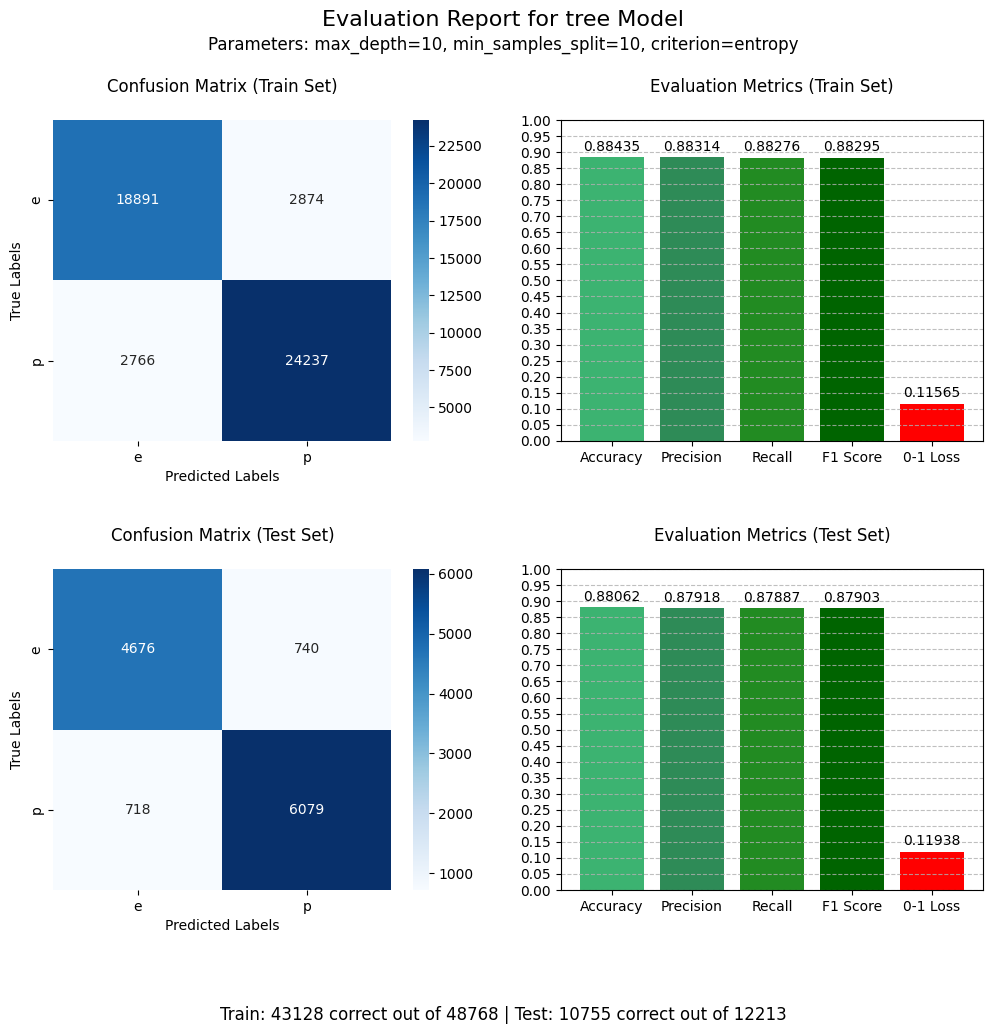

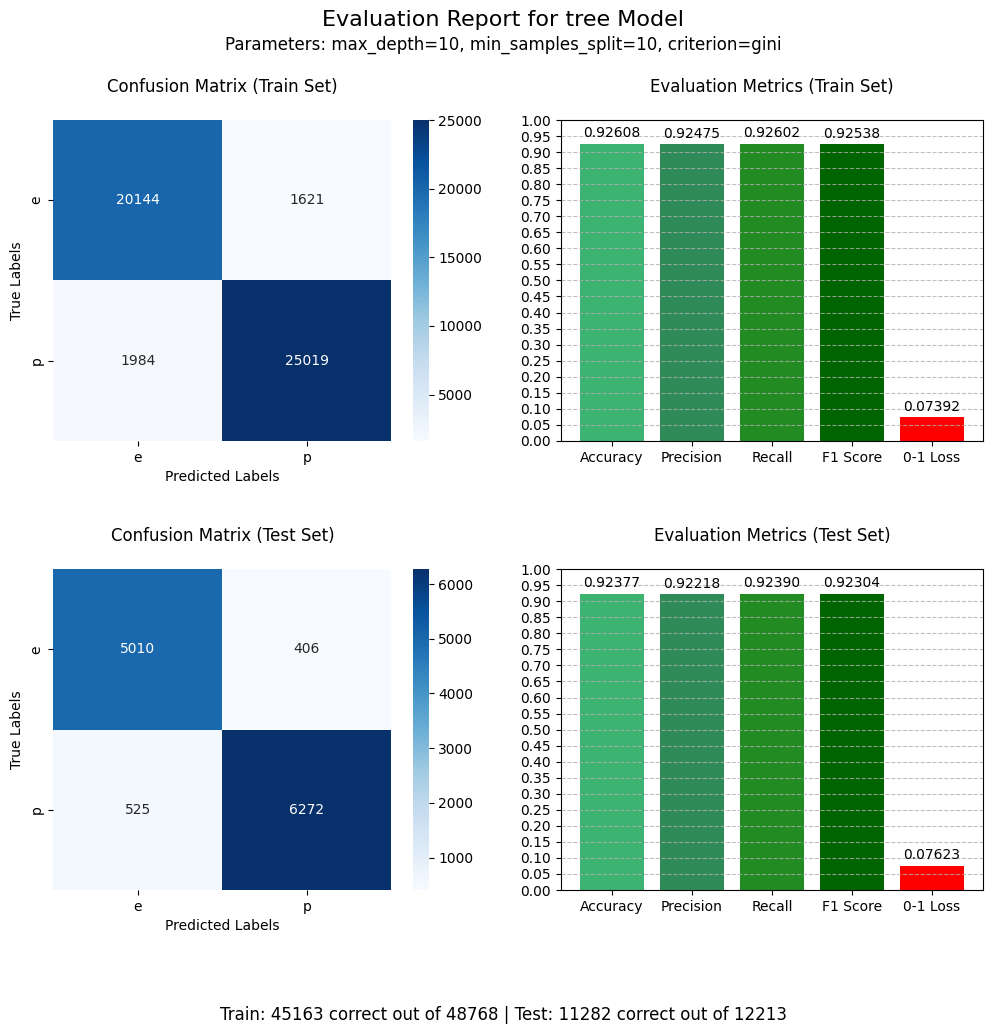

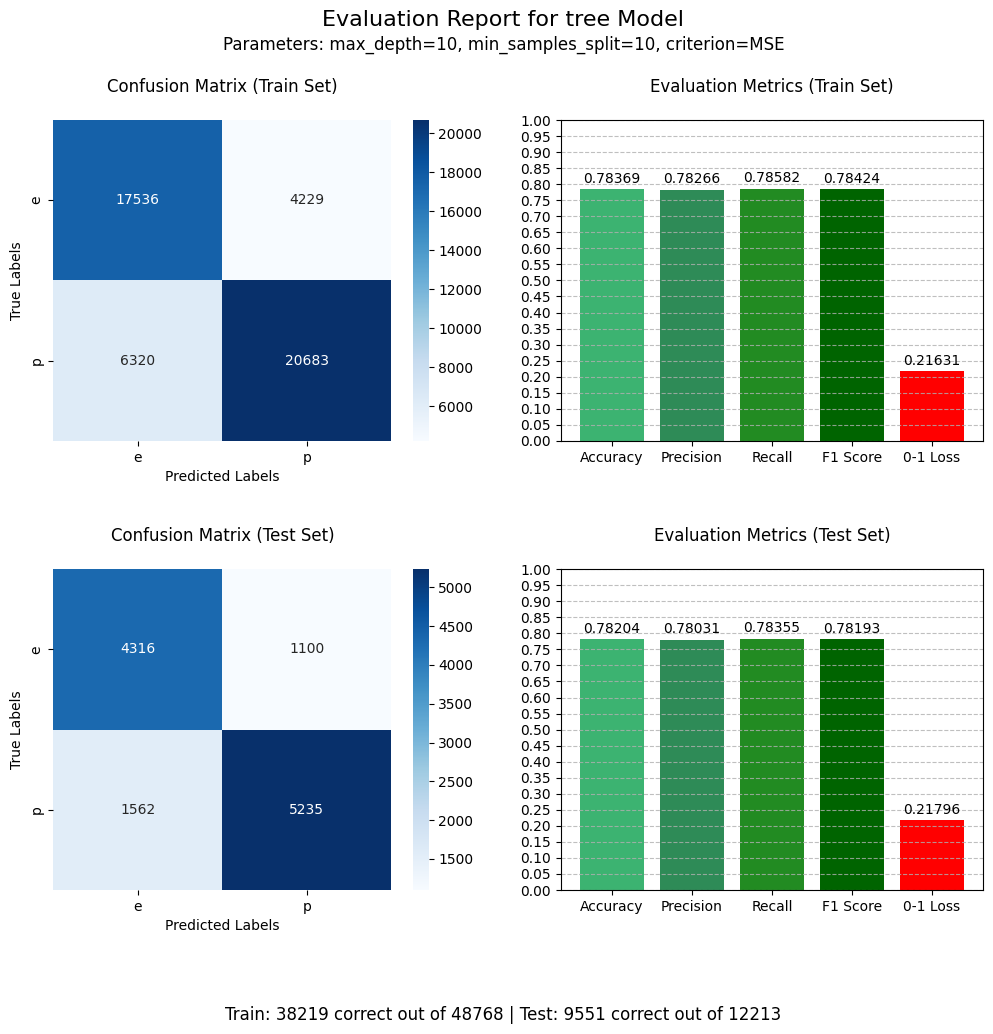

In [9]:
evaluator_entropy_train, evaluator_entropy_test = evaluation.evaluate_and_plot_train_and_test(tree_entropy, X_train, y_train, X_test, y_test)
evaluator_gini_train, evaluator_gini_test = evaluation.evaluate_and_plot_train_and_test(tree_gini, X_train, y_train, X_test, y_test)
evaluator_mse_train, evaluator_mse_test = evaluation.evaluate_and_plot_train_and_test(tree_mse, X_train, y_train, X_test, y_test)

This cell visualizes the decision trees obtained during training. The `TreeVisualizer` class from the `models` module is used to generate images of the decision trees, saved in the `imgs` directory and in PDF format for higher resolution.

Each visualization displays nodes with feature names, thresholds, and information gain (for split nodes) or predicted class (for leaf nodes), with edges labeled based on threshold conditions.

In [10]:
visualizer_entropy = models.TreeVisualizer(tree_entropy).draw_tree("Decision_tree_entropy")
visualizer_gini = models.TreeVisualizer(tree_gini).draw_tree("Decision_tree_gini")
visualizer_mse = models.TreeVisualizer(tree_mse).draw_tree("Decision_tree_MSE")

# Hyperparameter-Tuned Decision Tree Models: Fixed Split vs. $k$-Fold CV

The `perform_grid_search` function from the `hyperparameter_tuning` module performs a grid search over hyperparameters (`max_depth`, `min_samples_split`, `criterion`) for a `TreePredictor` model. Since no `cv` parameter is specified, **cross-validation is not used**. Instead, it:
- Trains multiple `TreePredictor` models on the training set.
- Evaluates them directly on the test set to select the best hyperparameters based on the highest test accuracy.
- The result, `best_params`, is a `pd.Series` containing the best hyperparameters, their achieved training and test accuracy and 0-1 loss, and the corresponding trained decision tree model.
  
The `evaluate_and_plot_train_and_test` function from the `evaluation` module evaluates the best model (`best_params.model`) on both the training set and test set. It:
- Computes performance metrics (accuracy, precision, recall, F1-score, 0-1 loss).
- Generates plots, including confusion matrices and metric bar charts, for both sets.
   
The `TreeVisualizer` class from the `models` module visualizes the structure of the best decision tree. The output is saved in the `imgs` directory.

Best parameters for tree:
  max_depth: 50
  min_samples_split: 10
  criterion: gini
  Train accuracy: 0.9998
  Train loss: 0.0002
  Test accuracy: 0.9984
  Test loss: 0.0016

Feature Importance (Best Tree (no CV)):
             Feature  Importance
     gill-attachment    4.343936
           cap-shape    3.034777
         cap-surface    2.991790
           cap-color    1.994309
        cap-diameter    1.853607
         stem-height    1.851957
          stem-width    1.744294
          gill-color    1.523414
        stem-surface    0.813620
           ring-type    0.790753
          stem-color    0.677129
        gill-spacing    0.513877
            has-ring    0.488689
does-bruise-or-bleed    0.145215
             habitat    0.113807
              season    0.000000


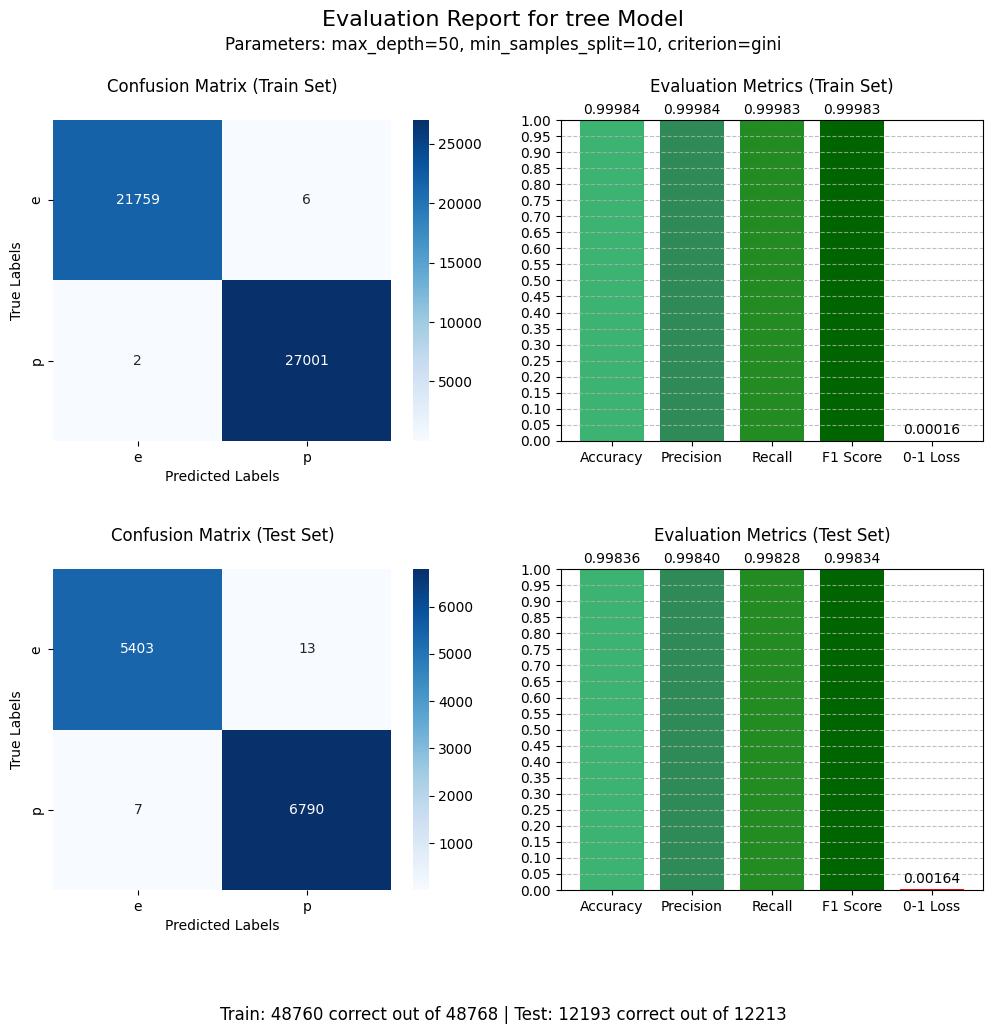

In [11]:
best_params = hyperparameter_tuning.perform_grid_search(X_train, y_train, X_test, y_test)
models.print_feature_importance(best_params.model, "tree", "Best Tree (no CV)")
evaluator_best_train, evaluator_best_test = evaluation.evaluate_and_plot_train_and_test(best_params.model, X_train, y_train, X_test, y_test)
visualizer_best_tree = models.TreeVisualizer(best_params.model).draw_tree("best_tree_no_cv")

This cell runs a $5$-fold grid search over the hyperparameters (`max_depth`, `min_samples_split`, `criterion`) using `perform_grid_search(..., cv=5)`. It:
- Finds the best hyperparameters by averaging accuracy over 5 folds. 
- Creates and trains a `TreePredictor` on the full training set with those CV-optimal parameters.  
- Evaluates performance on both the full training set and the full test set using `evaluate_and_plot_train_and_test(..., k_fold=5)`, producing metrics (accuracy, precision, recall, F1, 0-1 loss) and confusion matrices.  
- Visualizes and saves the resulting tree.

Best parameters for tree:
  max_depth: 50
  min_samples_split: 2
  criterion: MSE
  CV mean Test accuracy: 0.9981
  CV mean Test loss: 0.0019

Starting training of the decision tree using 
	- Splitting criterion = MSE
	- Maximum depth = 50
	- Minimum number of samples required in a node for splitting = 2 ...
Tree successfully fitted!


Feature Importance (Best Tree (using CV)):
             Feature  Importance
        cap-diameter    5.214324
         cap-surface    4.578565
          stem-width    3.109300
     gill-attachment    3.008207
         stem-height    2.749139
          gill-color    2.648566
           cap-shape    2.243097
           cap-color    1.889805
          stem-color    1.520431
        gill-spacing    0.531903
        stem-surface    0.501848
does-bruise-or-bleed    0.424188
           ring-type    0.334772
            has-ring    0.258614
              season    0.047925
             habitat    0.046812


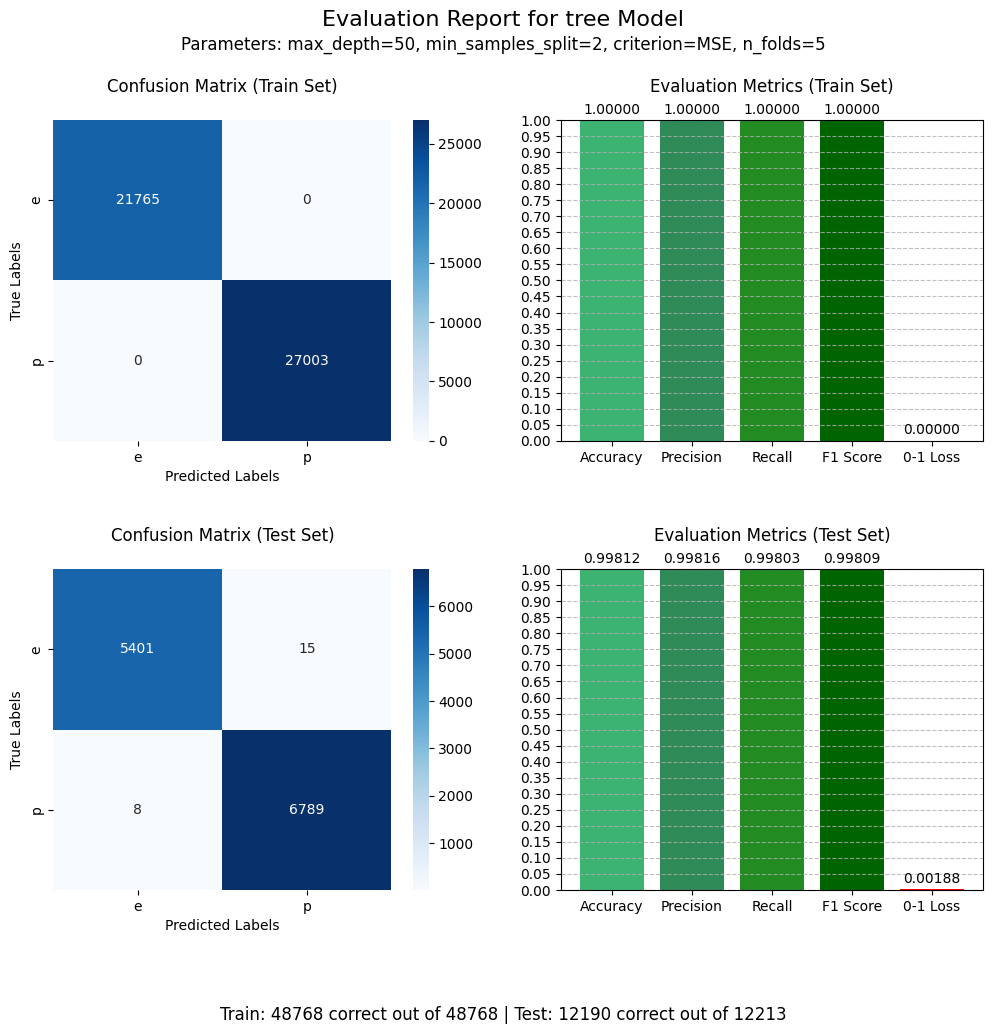

In [12]:
k_folds = 5

best_params_cv, best_tree_cv = hyperparameter_tuning.perform_grid_search(X_train, y_train, X_test, y_test, cv=k_folds)
models.print_feature_importance(best_tree_cv, "tree", "Best Tree (using CV)")
evaluator_best_cv_train, evaluator_best_cv_test = evaluation.evaluate_and_plot_train_and_test(best_tree_cv, X_train, y_train, X_test, y_test, k_fold=k_folds)
visualizer_best_tree_cv = models.TreeVisualizer(best_tree_cv).draw_tree("best_tree_using_cv")

This cell compares the test accuracies obtained using the best models from grid searches without cross-validation and with $5$-fold cross-validation. It selects the parameters (`best_params` or `best_params_cv`) with the higher test accuracy as `best_params_final`.

In [13]:
print("Test Accuracy Comparison:")
print(f"\t{'No Cross-Validation':<25}: {evaluator_best_test.accuracy()*100:.3f} %")
print(f"\t{'5-Fold Cross-Validation':<25}: {evaluator_best_cv_test.accuracy()*100:.3f} %")

if evaluator_best_test.accuracy() > evaluator_best_cv_test.accuracy():
    best_params_final = best_params
    method = "best hyperparameters found without using Cross-Validation"
elif evaluator_best_test.accuracy() == evaluator_best_cv_test.accuracy():
    best_params_final = best_params
    method = "best hyperparameters are the same using Cross-Validation and without using it"
else:
    best_params_final = best_params_cv
    method = "Best hyperparameters found using 5-Fold Cross-Validation"

print(f"\n\t=> Best Test Accuracy: {best_params_final['accuracy_test']*100:.3f} % ({method})")

Test Accuracy Comparison:
	No Cross-Validation      : 99.836 %
	5-Fold Cross-Validation  : 99.812 %

	=> Best Test Accuracy: 99.836 % (best hyperparameters found without using Cross-Validation)


# Plotting Accuracy and Loss vs. Max Depth

This cell plots accuracy and 0-1 loss versus `max_depth` (from 2 to 50, with step 3) for decision trees trained with optimal hyperparameters obtained from hyperparameter tuning.

 The `plot_accuracies_vs_depth` function generates subplots showing training and test accuracy and 0-1 loss on the y- axis and all `max_depth` values on the x-axis. 
 
 Parallel training of the trees ensures efficient computation.

Best model hyperparameters:
max_depth                                                           50
min_samples_split                                                   10
criterion                                                         gini
accuracy_train                                                0.999836
accuracy_test                                                 0.998362
loss_train                                                    0.000164
loss_test                                                     0.001638
model                <models.TreePredictor object at 0x000001BD823A...
Name: 21, dtype: object

Starting accuracy and 0-1 loss plotting, using best hyperparameters (found without using cross-validation)...
...building and evaluating 17 trees using parallel computation...

Performance metrics for each max_depth:
max_depth=2: Train Accuracy=0.65049, Test Accuracy=0.65234, Train 0-1 Loss=0.34951, Test 0-1 Loss=0.34766
max_depth=5: Train Accuracy=0.73101, Test Accuracy=0.734

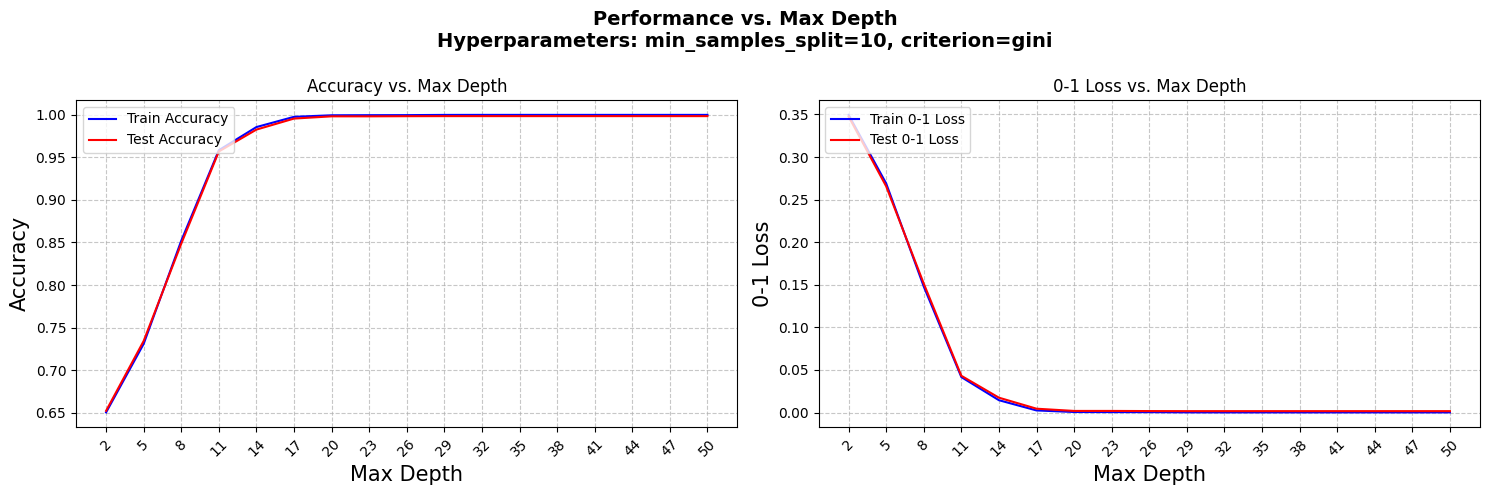

In [14]:
print("Best model hyperparameters:\n", best_params_final, sep="", end="\n"*2)
print("Starting accuracy and 0-1 loss plotting, using best hyperparameters (found without using cross-validation)...")
evaluation.plot_performance_vs_depth(X_train, y_train, X_test, y_test, best_params_final)

# Random Forest Models
This cell trains and evaluates a Random Forest classifier using the best hyperparameters (`best_params`) that achieved the highest accuracy from hyperparameter tuning on trees, comparing `best_params` (no cross-validation) and `best_params_cv` (cross-validation). 

The Random Forest is implemented with:
- `RandomTreePredictor`: extends `TreePredictor` to include random feature subsampling at each split, controlled by `max_features`.
- `RandomForest`: builds an ensemble of `RandomTreePredictor` trees, using bootstrap sampling and parallel training. 


Starting training of the Random Forest model using 
	- Number of estimators = 10               
	- Number of features to consider per split = sqrt(16) = 4               
	- Splitting criterion = gini
	- Maximum depth = 50               
	- Minimum number of samples required in a node for splitting = 10 ...
Random Forest with 10 trees successfully fitted!

Feature Importance (Random Forest):
             Feature  Importance
          stem-width    6.147447
         cap-surface    4.414917
     gill-attachment    3.989501
          gill-color    3.737215
         stem-height    3.669869
        cap-diameter    3.165340
           cap-color    3.066379
           cap-shape    2.596481
          stem-color    2.581329
        gill-spacing    1.639135
            has-ring    1.430234
        stem-surface    1.364481
             habitat    1.215380
does-bruise-or-bleed    1.127002
           ring-type    1.014557
              season    0.949178


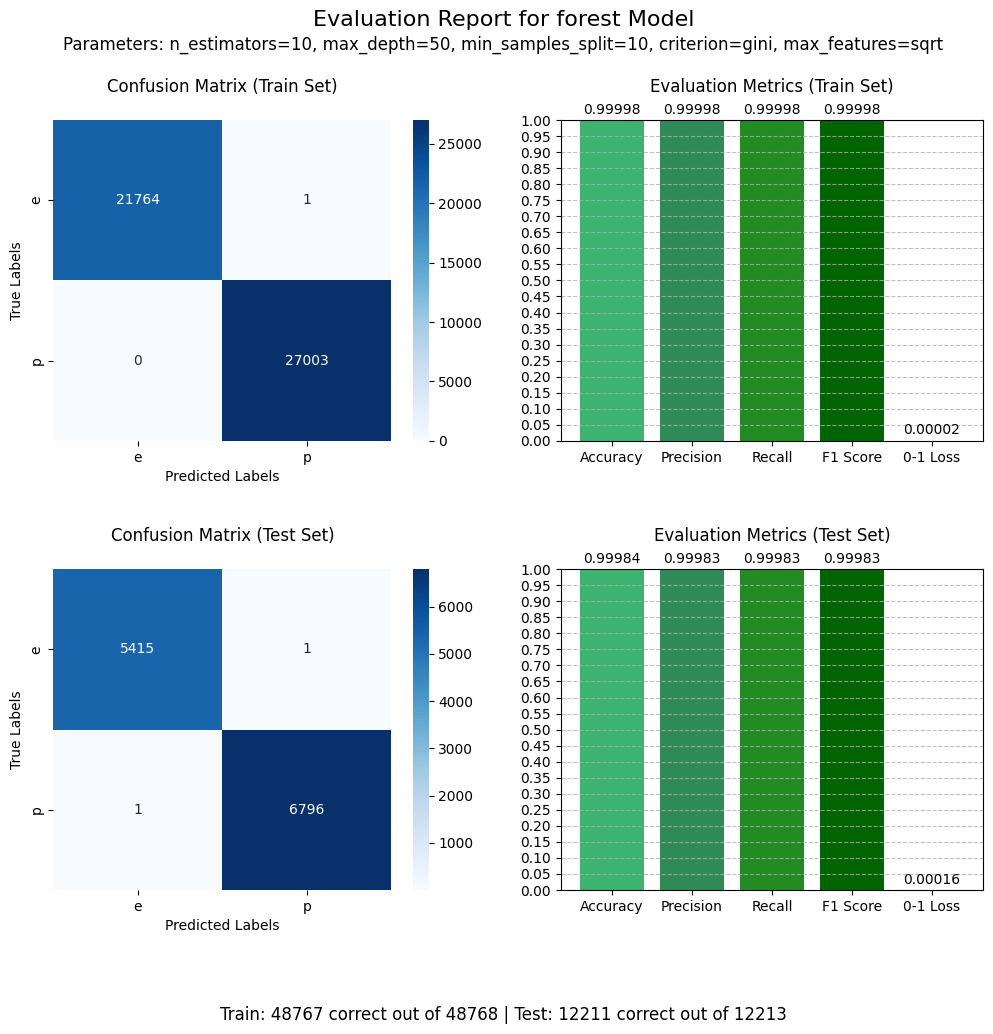

In [15]:
rf = models.RandomForest(
    n_estimators=10,
    max_depth=best_params_final['max_depth'],
    min_samples_split=best_params_final['min_samples_split'],
    criterion=best_params_final['criterion'],
    max_features="sqrt"
)
rf.fit(X_train, y_train)
models.print_feature_importance(rf, "forest", "Random Forest")
evaluator_rf_train, evaluator_rf_test = evaluation.evaluate_and_plot_train_and_test(rf, X_train, y_train, X_test, y_test, model_type="forest")

# Hyperparameter-Tuned Random Forest Models

The `perform_grid_search` function from the `hyperparameter_tuning` module runs a grid search for a `RandomForest` model over hyperparameters (`n_estimators`, `max_depth`, `min_samples_split`, `criterion`, `max_features`), without cross-validation. It:
- Trains multiple `RandomForest` models on the training set.
- Evaluates them on the test set to select the best hyperparameters based on test accuracy.
- Returns the best hyperparameters, training and test accuracy, 0-1 loss, and the best `RandomForest` model trained with the best hyperparameters.
  
The `predict_and_evaluate` method predicts labels for the test set and returns the number of correct predictions, the number of total samples and the 0-1 loss.

The `Evaluation` class creates an `evaluator_best_rf` object that compute performance metrics (accuracy, precision, recall, F1-score, 0-1 loss). The `plot_report` method displays a graphical report for the test set, showing a confusion matrix heatmap, a bar chart of metrics, and the number of correct predictions out of the total.

Best parameters for forest:
  n_estimators: 20
  max_depth: 30
  min_samples_split: 2
  criterion: entropy
  max_features: sqrt
  Train accuracy: 1.0000
  Train loss: 0.0000
  Test accuracy: 1.0000
  Test loss: 0.0000

Feature Importance (Best Random Forest):
             Feature  Importance
          stem-width    6.044555
     gill-attachment    4.847652
         cap-surface    4.772681
          gill-color    4.445033
         stem-height    4.166624
        cap-diameter    4.031080
          stem-color    3.576893
           cap-color    3.498565
           cap-shape    3.009102
        stem-surface    2.083260
        gill-spacing    1.681091
             habitat    1.597444
            has-ring    1.419036
           ring-type    1.385606
does-bruise-or-bleed    1.317411
              season    1.079300


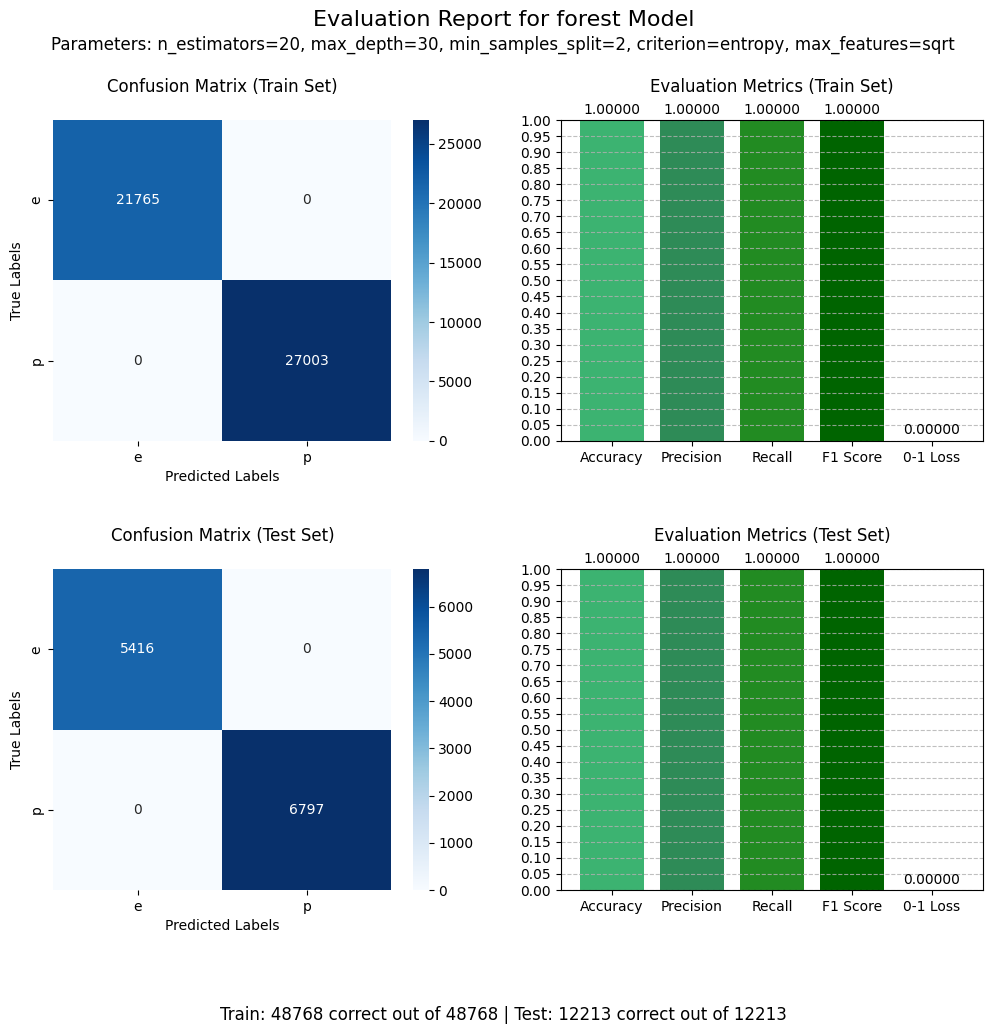

In [16]:
best_params_rf = hyperparameter_tuning.perform_grid_search(X_train, y_train, X_test, y_test, model_type="forest")
models.print_feature_importance(best_params_rf.model, "forest", "Best Random Forest")
evaluator_best_rf_train, evaluator_best_rf_test = evaluation.evaluate_and_plot_train_and_test(best_params_rf.model, X_train, y_train, X_test, y_test, model_type="forest")